In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# install external library for text augmentation
!pip install nlpaug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# plotting libraries
import seaborn as sn 
import matplotlib.pyplot as plt
import plotly.graph_objects as go # Plotly for interactive data visualizatoins

import re # regex for text cleaning
import nltk # natural language processing tool kit
import pickle # for saving/serializing machine learning models
import nlpaug.augmenter.word as naw # text augmentor
# neural networks and embeddings stuff
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.layers.embeddings import Embedding

from nltk.stem import WordNetLemmatizer # lemmatizing tool
from sklearn.feature_extraction.text import TfidfVectorizer # tfidf for text representation
from sklearn.model_selection import train_test_split # for data splitting
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score # for classifier evaluation
from sklearn.ensemble import RandomForestClassifier # random forest machine learning model
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

     |████████████████████████████████| 81kB 3.1MB/s 


Using TensorFlow backend.


/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/twitter-airline-sentiment/Tweets.csv


In [2]:
# read csv file into a dataframe
raw_tweets=pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
# show sample of data
raw_tweets.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7627,569496729755652098,neutral,0.6316,NaN,0.000,Delta,NaN,MegBurns,NaN,0,@JetBlue on flight 622 from Nassau to JFK. Not...,"[25.05152514, -77.46620117]",2015-02-22 05:59:35 -0800,"west hartford, connecticut",Eastern Time (US & Canada)
14475,569609887388270592,negative,1.0000,Flight Booking Problems,0.363,American,NaN,PredsFran,NaN,0,@AmericanAir Changed flight from BNA to 2/20 a...,NaN,2015-02-22 13:29:14 -0800,Tennessee,Central Time (US & Canada)
2640,568976065210806272,negative,1.0000,Customer Service Issue,1.000,United,NaN,The_CW,NaN,1,@united never flying with you guys ever again....,NaN,2015-02-20 19:30:39 -0800,Ho-Flo/Columbus/NYC,Central Time (US & Canada)
3473,568412546673352705,positive,0.6630,NaN,NaN,United,NaN,DMSHIPMAN915,NaN,0,@united followed and messaged. Thanks so much ...,NaN,2015-02-19 06:11:26 -0800,Germany,NaN
11175,568457663123746816,negative,1.0000,Customer Service Issue,1.000,US Airways,NaN,bambiweavil,NaN,0,@USAirways I've been on a music hold for over ...,NaN,2015-02-19 09:10:42 -0800,"New York, NY | Brooklyn",Eastern Time (US & Canada)


**Exploratory Analysis**

When we notice the nature of our dataset , that most of features are categorical features , 
so i think that par and pie plots should be a very good visualization techinques for our dataset EDA


**Stacked par chart to show the distribution of reviews per company**

In [3]:
crosstab_sentiments=pd.crosstab(raw_tweets.airline, raw_tweets.airline_sentiment)
companies=list(crosstab_sentiments.index)

fig = go.Figure(data=[
    go.Bar(name=col_name, x=companies, y=list(crosstab_sentiments[col_name]))
for col_name in list(crosstab_sentiments.columns)])
# Change the bar mode
fig.update_layout(barmode='stack',
                  title='Sentiment distribution per company',
                  yaxis=dict(title='Sentiment distribution'),
                 xaxis=dict(title='Companies'))
fig.show()

we see that most of reviews are negative for most of the companies , to help these companies take better decesions we need to focus on negative reviews


**Stacked par chart to show negative reasons distributions per company**

In [4]:
crosstab_neg_reasons=pd.crosstab(raw_tweets.airline,raw_tweets.negativereason)
companies=list(crosstab_neg_reasons.index)

fig = go.Figure(data=[
    go.Bar(name=col_name, x=companies, y=list(crosstab_neg_reasons[col_name]))
for col_name in list(crosstab_neg_reasons.columns)])
# Change the bar mode
fig.update_layout(barmode='stack',
                  title='Negative reasons distribution per company',
                  yaxis=dict(title='Negative reasons distribution'),
                 xaxis=dict(title='Companies'))
fig.show()

**Pie plot to check the overall distribution for negative reasons**

In [5]:
labels = list(crosstab_neg_reasons.columns)
values = [crosstab_neg_reasons[col_name].sum() for col_name in labels]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title='Overall distribution for negative reasons')
fig.show()

**Par plot to show sentiment class distributions**

In [6]:
fig = go.Figure(
    [go.Bar(x=list(raw_tweets['airline_sentiment'].unique()),
            y=raw_tweets['airline_sentiment'].value_counts())]
)
# Change the bar mode
fig.update_layout(
                  title='Sentiment distribution',
                  yaxis=dict(title='Count'),
                 xaxis=dict(title='Sentiment'))
fig.show()

from previous plot , we notice that the dataset may suffer from class imbalance problem , we may try to oversample the minority classes using text augmentation technique , nlpaug is very helpful tool , I will use it to oversample neutral and positive classes , note : nlpaug does not blindly copies data , but it apply random word variations with the same meaninig (high cosine similarity)
check text augmentation section below after data cleaning and stemming

Now we shall start second part of the problem , we need to build an efficient text / sentiment classifier to predict customer review sentiment

**Text cleaning and preprocessing**

In [7]:
def clean_text(dataframe):
    '''
    function to clean tweets dataframe text , eg : remove white spaces , special chars and website urls
    '''
    # select nedded columns
    dataframe=dataframe[['airline_sentiment','text']]
    # drop nans
    dataframe=dataframe.dropna()
    # convert review into lower case
    dataframe['text']=dataframe['text'].apply(lambda row : row.lower())
    # remove numbers
    dataframe['text']=dataframe['text'].apply(lambda row : re.sub('\d+','',row))
    # remove tweet account name
    dataframe['text']=dataframe['text'].apply(lambda row:re.sub(r'@\w+', '',row))
    # remove website urls
    dataframe['text']=dataframe['text'].apply(lambda row:re.sub(r'http\S+', '',row))
    # rwmove special characters
    dataframe['text']=dataframe['text'].apply(lambda row:re.sub(r"[^A-Za-z0-9']+", ' ',row))
    # remove white spaces
    dataframe['text']=dataframe['text'].apply(lambda row:re.sub(r'\s+', ' ',row))
    
    return dataframe

traindf=clean_text(raw_tweets)

In [8]:
lem = WordNetLemmatizer()
def stem_review(review):
    return ' '.join([lem.lemmatize(word) for word in review.split(' ')])
def normalize_text(dataframe):
    '''
    function used for rooting / stemming tokens
    '''
    dataframe['text']=dataframe['text'].apply(lambda x : stem_review(x))

normalize_text(traindf)

now we will build a classifier using classical machine learning algorithms , then we will use advanced deep learning techniques , from my experience with text classifiers the combination between Tfidfvectorizer with Random forest algorithm has never failed me :)

**Text augmentation**

to solve class imbalance problem we shall augment/oversample minor classes

In [9]:
def augment_text(dataframe):
    '''
    function used to augment minor classes in tweets dataset
    '''
    augmented_df = pd.DataFrame(columns=['text', 'airline_sentiment'])
    augmentor=naw.WordNetAug(aug_p=0.5)
    aug_sent={'neutral':3,
             'positive':4}
    for i in range(len(dataframe)):
        current_label=dataframe['airline_sentiment'].iloc[i]
        if current_label in list(aug_sent.keys()):
            current_text=dataframe['text'].iloc[i]
            for j in range(aug_sent[current_label]):
                text = augmentor.augment(current_text)
                label = current_label
                tempdf = pd.DataFrame(list(zip([text], [label])), columns=['text', 'airline_sentiment'])
                augmented_df = augmented_df.append(tempdf)
        else :
                text = dataframe['text'].iloc[i]
                label = current_label
                tempdf = pd.DataFrame(list(zip([text], [label])), columns=['text', 'airline_sentiment'])
                augmented_df = augmented_df.append(tempdf)
    return augmented_df
augmented_traindf=augment_text(traindf)

/opt/conda/lib/python3.6/site-packages/nlpaug/util/decorator/deprecation.py:27: DeprecationWarning:

Class WordNetAug is deprecated from 0.0.9 version. It will be removed from 0.0.11 version. Use Synonym from 0.0.9 version



**Text Representation**

i will use TfidfVectorizer for sentiment vectorization , from many experiments i have done before with sentiment/reviews datasets , below configuration gives good results 

In [10]:
# convert text into numeric values using tf-idf vectorizer
tfidfconverter = TfidfVectorizer(
                                 min_df=5, 
                                 max_df=0.7,
                                 ngram_range=(1,2),
                                 stop_words='english'
                                )  
X = tfidfconverter.fit_transform(augmented_traindf['text']).toarray()
y = augmented_traindf['airline_sentiment'].values

**Model training**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
text_classifier = RandomForestClassifier(n_estimators=400,n_jobs=-1,verbose=True)
text_classifier.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 16.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=True, warm_start=False)

**Model evaluation**

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    2.2s finished


Classification Report :
               precision    recall  f1-score   support

    negative       0.84      0.87      0.85      1835
     neutral       0.77      0.79      0.78      1857
    positive       0.84      0.79      0.81      1894

    accuracy                           0.81      5586
   macro avg       0.82      0.81      0.81      5586
weighted avg       0.82      0.81      0.81      5586
 
 Model Acurracy = 0.8145363408521303

 Confusion Matrix


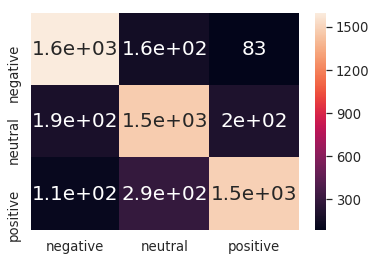

In [12]:
# model testing
predictions = text_classifier.predict(X_test)
print("Classification Report :\n {} \n Model Acurracy = {}".format(classification_report(y_test,predictions),
                                                                 accuracy_score(y_test, predictions)))
# confusion matrix
print("\n Confusion Matrix")
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions),['negative','neutral','positive'],['negative','neutral','positive'])
sn.set(font_scale=1.2)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 20})


the model shows good performance in the evaluation stage , so we may save it to a use as a base model for future enhancements

In [13]:
pkl_filename = "classifier_random_forest.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(text_classifier, file)
print("Model Saved")

Model Saved


**Classification using Deep learning techniques**


we will train an **embedding layer followed by dense layer of 3 neurons with batch size =32 for 4 epochs** , i choosed this arhitecture to keep the network simple as i tried adding more dense layers and the model was training for 10 epochs but the model has symptoms of overfitting also the train and validation error curves were increasing after 4 epochs .

train an embedding layer with Fully connected neural network

In [14]:
ycat=pd.get_dummies(augmented_traindf['airline_sentiment']).values
X=augmented_traindf['text'].values
tk = Tokenizer()
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X_pad, ycat, test_size = 0.25, random_state = 1)

In [15]:
vocabulary_size = len(tk.word_counts.keys())+1
max_words = 100
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           476032    
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9603      
Total params: 485,635
Trainable params: 485,635
Non-trainable params: 0
_________________________________________________________________


In [16]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=32,epochs=4,verbose=True)

Train on 20945 samples, validate on 6982 samples
Epoch 1/4
20945/20945 [==============================] - 3s 167us/step - loss: 0.6613 - accuracy: 0.7175 - val_loss: 0.4055 - val_accuracy: 0.8506
Epoch 2/4
20945/20945 [==============================] - 3s 149us/step - loss: 0.2838 - accuracy: 0.9044 - val_loss: 0.2979 - val_accuracy: 0.8910
Epoch 3/4
20945/20945 [==============================] - 3s 141us/step - loss: 0.1669 - accuracy: 0.9496 - val_loss: 0.2558 - val_accuracy: 0.9050
Epoch 4/4
20945/20945 [==============================] - 3s 139us/step - loss: 0.1059 - accuracy: 0.9712 - val_loss: 0.2423 - val_accuracy: 0.9089


visualizing model behavior during training

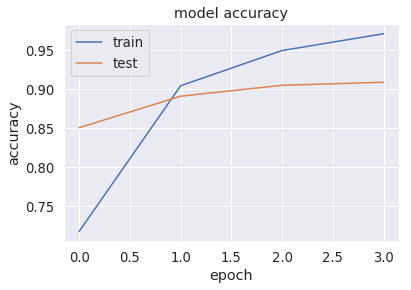

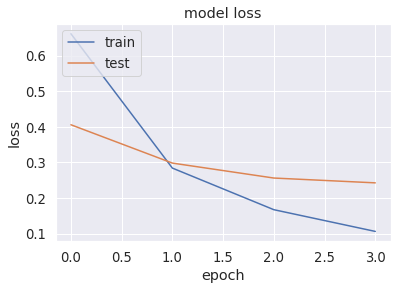

In [17]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Classification Report :
               precision    recall  f1-score   support

    negative       0.94      0.94      0.94      2268
     neutral       0.88      0.89      0.89      2312
    positive       0.91      0.90      0.90      2402

    accuracy                           0.91      6982
   macro avg       0.91      0.91      0.91      6982
weighted avg       0.91      0.91      0.91      6982
 
 Model Acurracy = 0.9089086221712976

 Confusion Matrix


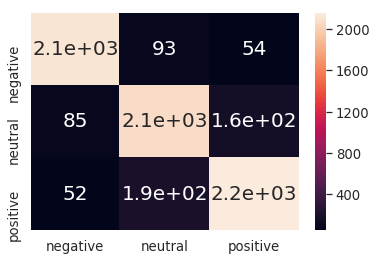

In [18]:
# model testing
predictions = [np.argmax(i) for i in model.predict(X_test)]
y_test=[np.argmax(i) for i in y_test]
print("Classification Report :\n {} \n Model Acurracy = {}".format(classification_report(y_test,predictions,
                                                                                         target_names=['negative','neutral','positive']),
                                                                 accuracy_score(y_test, predictions)))
# confusion matrix
print("\n Confusion Matrix")
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions),['negative','neutral','positive'],['negative','neutral','positive'])
sn.set(font_scale=1.2)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 20})

the model shows good performance in the evaluation stage , so we may save it to a use as a base model for future enhancements

In [19]:
model.save('text_classifier_neural_network.h5')
print('model_saved')

model_saved


finally as it was predicted , training an embedding layer with fully connected neural network (deep learning methods) shows better performance than conventional text vectorization techniques and machine learning algorithms